<a href="https://colab.research.google.com/github/RichmondCap/trend-following/blob/main/10_21_SMA_3sectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy yfinance pyfolio-reloaded matplotlib
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
import warnings
from IPython.display import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
# Ignore printing all warnings
warnings.filterwarnings('ignore')

# downloading historical data
_start = dt.date(2000,1,2)
_end = dt.date(2023,9,30)
SPY_df = yf.download('SPY', start = _start, end = _end)
XLE_df = yf.download('XLE', start = _start, end = _end)
XLK_df = yf.download('XLK', start = _start, end = _end)

# buy and hold returns calc
SPY_df['bnh_returns'] = np.log(SPY_df['Adj Close']/SPY_df['Adj Close'].shift(1))
XLE_df['bnh_returns'] = np.log(XLE_df['Adj Close']/XLE_df['Adj Close'].shift(1))
XLK_df['bnh_returns'] = np.log(XLK_df['Adj Close']/XLK_df['Adj Close'].shift(1))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Creating 20-day SMA columns for each dataframe
SPY_df['20_SMA'] = SPY_df['Adj Close'].rolling(window=10).mean()
XLE_df['20_SMA'] = XLE_df['Adj Close'].rolling(window=10).mean()
XLK_df['20_SMA'] = XLK_df['Adj Close'].rolling(window=10).mean()

# Creating 50-day SMA columns for each dataframe
SPY_df['50_SMA'] = SPY_df['Adj Close'].rolling(window=21).mean()
XLE_df['50_SMA'] = XLE_df['Adj Close'].rolling(window=21).mean()
XLK_df['50_SMA'] = XLK_df['Adj Close'].rolling(window=21).mean()

# Drop the first 50 Rows (used to calculate indicators only)
SPY_df.drop(SPY_df.head(50).index,inplace=True)

# Creating a signal column
SPY_df['Long'] = 0
XLE_df['Long'] = 0
XLK_df['Long'] = 0

SPY_df['Short'] = 0
XLE_df['Short'] = 0
XLK_df['Short'] = 0

# Buy signal for long positions
SPY_df['Long'] = (SPY_df['20_SMA'] > SPY_df['50_SMA']) & ~(SPY_df['20_SMA'].shift(1) > SPY_df['50_SMA'].shift(1))
SPY_df['Long'] = SPY_df['Long'].astype(int)

# Sell signal for short positions
SPY_df['Short'] = (SPY_df['20_SMA'] < SPY_df['50_SMA']) & ~(SPY_df['20_SMA'].shift(1) < SPY_df['50_SMA'].shift(1))
SPY_df['Short'] = SPY_df['Short'].astype(int) * -1

# Returns of the strategy
SPY_df['Strategy Returns'] = 0.0

# Calculate strategy returns
in_position = False
for i in range(1, len(SPY_df)):
    if SPY_df['Long'][i] == 1:
        SPY_df['Strategy Returns'][i] = SPY_df['bnh_returns'][i]
        in_position = True
    elif SPY_df['Short'][i] == -1:
        SPY_df['Strategy Returns'][i] = SPY_df['bnh_returns'][i] * -1
        in_position = False
    elif in_position:
        SPY_df['Strategy Returns'][i] = SPY_df['bnh_returns'][i]
    else:
        SPY_df['Strategy Returns'][i] = SPY_df['bnh_returns'][i] * -1

display(SPY_df)

,Open,High,Low,Close,Adj Close,Volume,bnh_returns,20_SMA,50_SMA,Long,Short,Strategy Returns
Date,,,,,,,,,,,,
2000-03-15,136.875000,140.437500,136.062500,139.812500,90.616837,10300800,0.023062,90.048701,89.309476,1,0,0.000000
2000-03-16,141.625000,146.843750,140.875000,146.343750,94.849937,25601400,0.045656,90.555053,89.471991,0,0,-0.045656
2000-03-17,145.812500,148.000000,145.437500,146.937500,95.476791,10272900,0.006587,90.955984,89.728494,0,0,-0.006587
2000-03-20,146.875000,147.343750,144.781250,146.187500,94.989464,12502300,-0.005117,91.397298,89.983974,0,0,0.005117
2000-03-21,145.531250,149.750000,144.500000,149.187500,96.938835,13612600,0.020314,92.208749,90.423906,0,0,-0.020314
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,429.170013,432.269989,428.720001,432.230011,432.230011,70874500,0.004196,440.052997,442.950524,0,0,-0.004196
2023-09-26,429.089996,429.820007,425.019989,425.880005,425.880005,96168400,-0.014800,438.198761,442.353213,0,0,0.014800
2023-09-27,427.089996,427.670013,422.290009,426.049988,426.049988,104705800,0.000399,436.309705,441.631606,0,0,-0.000399


In [5]:
# Buy signal for long positions
XLE_df['Long'] = (XLE_df['20_SMA'] > XLE_df['50_SMA']) & ~(XLE_df['20_SMA'].shift(1) > XLE_df['50_SMA'].shift(1))
XLE_df['Long'] = XLE_df['Long'].astype(int)

# Sell signal for short positions
XLE_df['Short'] = (XLE_df['20_SMA'] < XLE_df['50_SMA']) & ~(XLE_df['20_SMA'].shift(1) < XLE_df['50_SMA'].shift(1))
XLE_df['Short'] = XLE_df['Short'].astype(int) * -1

# Returns of the strategy
XLE_df['Strategy Returns'] = 0.0

# Calculate strategy returns
in_position = False
for i in range(1, len(XLE_df)):
    if XLE_df['Long'][i] == 1:
        XLE_df['Strategy Returns'][i] = XLE_df['bnh_returns'][i]
        in_position = True
    elif XLE_df['Short'][i] == -1:
        XLE_df['Strategy Returns'][i] = XLE_df['bnh_returns'][i] * -1
        in_position = False
    elif in_position:
        XLE_df['Strategy Returns'][i] = XLE_df['bnh_returns'][i]
    else:
        XLE_df['Strategy Returns'][i] = XLE_df['bnh_returns'][i] * -1

In [6]:
# Buy signal for long positions
XLK_df['Long'] = (XLK_df['20_SMA'] > XLK_df['50_SMA']) & ~(XLK_df['20_SMA'].shift(1) > XLK_df['50_SMA'].shift(1))
XLK_df['Long'] = XLK_df['Long'].astype(int)

# Sell signal for short positions
XLK_df['Short'] = (XLK_df['20_SMA'] < XLK_df['50_SMA']) & ~(XLK_df['20_SMA'].shift(1) < XLK_df['50_SMA'].shift(1))
XLK_df['Short'] = XLK_df['Short'].astype(int) * -1

# Returns of the strategy
XLK_df['Strategy Returns'] = 0.0

# Calculate strategy returns
in_position = False
for i in range(1, len(XLK_df)):
    if XLK_df['Long'][i] == 1:
        XLK_df['Strategy Returns'][i] = XLK_df['bnh_returns'][i]
        in_position = True
    elif XLK_df['Short'][i] == -1:
        XLK_df['Strategy Returns'][i] = XLK_df['bnh_returns'][i] * -1
        in_position = False
    elif in_position:
        XLK_df['Strategy Returns'][i] = XLK_df['bnh_returns'][i]
    else:
        XLK_df['Strategy Returns'][i] = XLK_df['bnh_returns'][i] * -1


SPY Buy and Hold Returns: 1.5743299639343367
SPY Strategy Returns: 1.932321921696372
XLE Buy and Hold Returns: 1.8339260890919697
XLE Strategy Returns: 3.6928757767961864
XLK Buy and Hold Returns: 1.3632299407760224
XLK Strategy Returns: 2.6686188552800028


Start date,2000-03-15
End date,2023-09-29
Total months,282
,Backtest
Annual return,6.498%
Cumulative returns,339.301%
Annual volatility,19.62%
Sharpe ratio,0.42
Calmar ratio,0.19
Stability,0.85
Max drawdown,-33.436%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.44,2013-06-24,2018-12-03,2020-03-12,1754
1,32.97,2008-11-20,2010-07-15,2013-01-29,1094
2,28.19,2002-10-09,2006-08-09,2008-07-02,1496
3,26.05,2021-11-18,2022-07-14,2023-07-12,430
4,24.16,2000-04-14,2001-01-03,2001-06-14,305


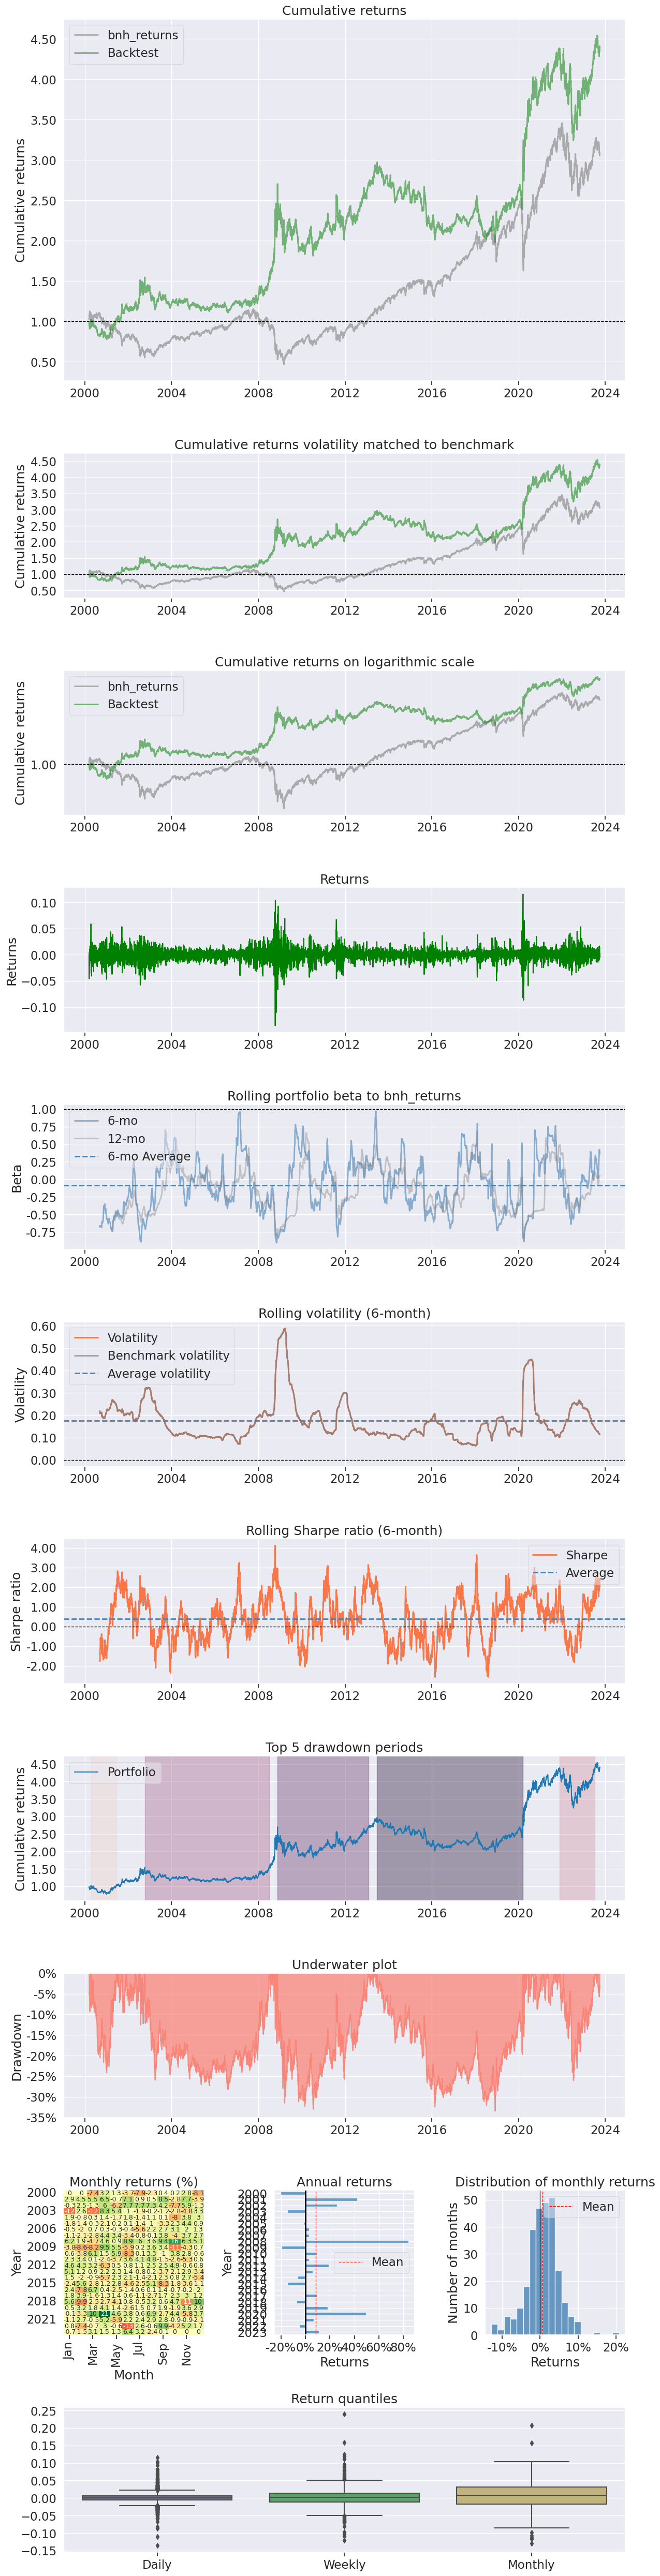

In [7]:
# Print out Returns
print("SPY Buy and Hold Returns:", SPY_df['bnh_returns'].sum())
print("SPY Strategy Returns:", SPY_df['Strategy Returns'].sum())

print("XLE Buy and Hold Returns:", XLE_df['bnh_returns'].sum())
print("XLE Strategy Returns:", XLE_df['Strategy Returns'].sum())

print("XLK Buy and Hold Returns:", XLK_df['bnh_returns'].sum())
print("XLK Strategy Returns:", XLK_df['Strategy Returns'].sum())

# Analysis
pf.create_returns_tear_sheet(SPY_df['Strategy Returns'], benchmark_rets = SPY_df['bnh_returns'])

This strategy performs relatively well during periods of downturn due to the shorting aspect. However, during periods of steady incline or flat trading, the strategy underperforms the market. Using a larger moving average such as the 100MA or 50MA to determine when to begin implementing this strategy may provide stronger results. With a longer term moving average crossover strategy being used when trading at less extreme levels.

Start date,2000-01-03
End date,2023-09-29
Total months,284
,Backtest
Annual return,11.876%
Cumulative returns,1330.023%
Annual volatility,29.592%
Sharpe ratio,0.53
Calmar ratio,0.17
Stability,0.60
Max drawdown,-70.885%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,70.88,2008-10-27,2010-07-13,2020-02-26,2958
1,41.49,2000-02-25,2001-05-30,2002-07-22,627
2,31.91,2020-06-08,2021-02-10,2021-10-15,355
3,28.55,2005-09-29,2006-03-16,2007-04-10,399
4,24.34,2020-03-18,2020-03-26,2020-05-27,51


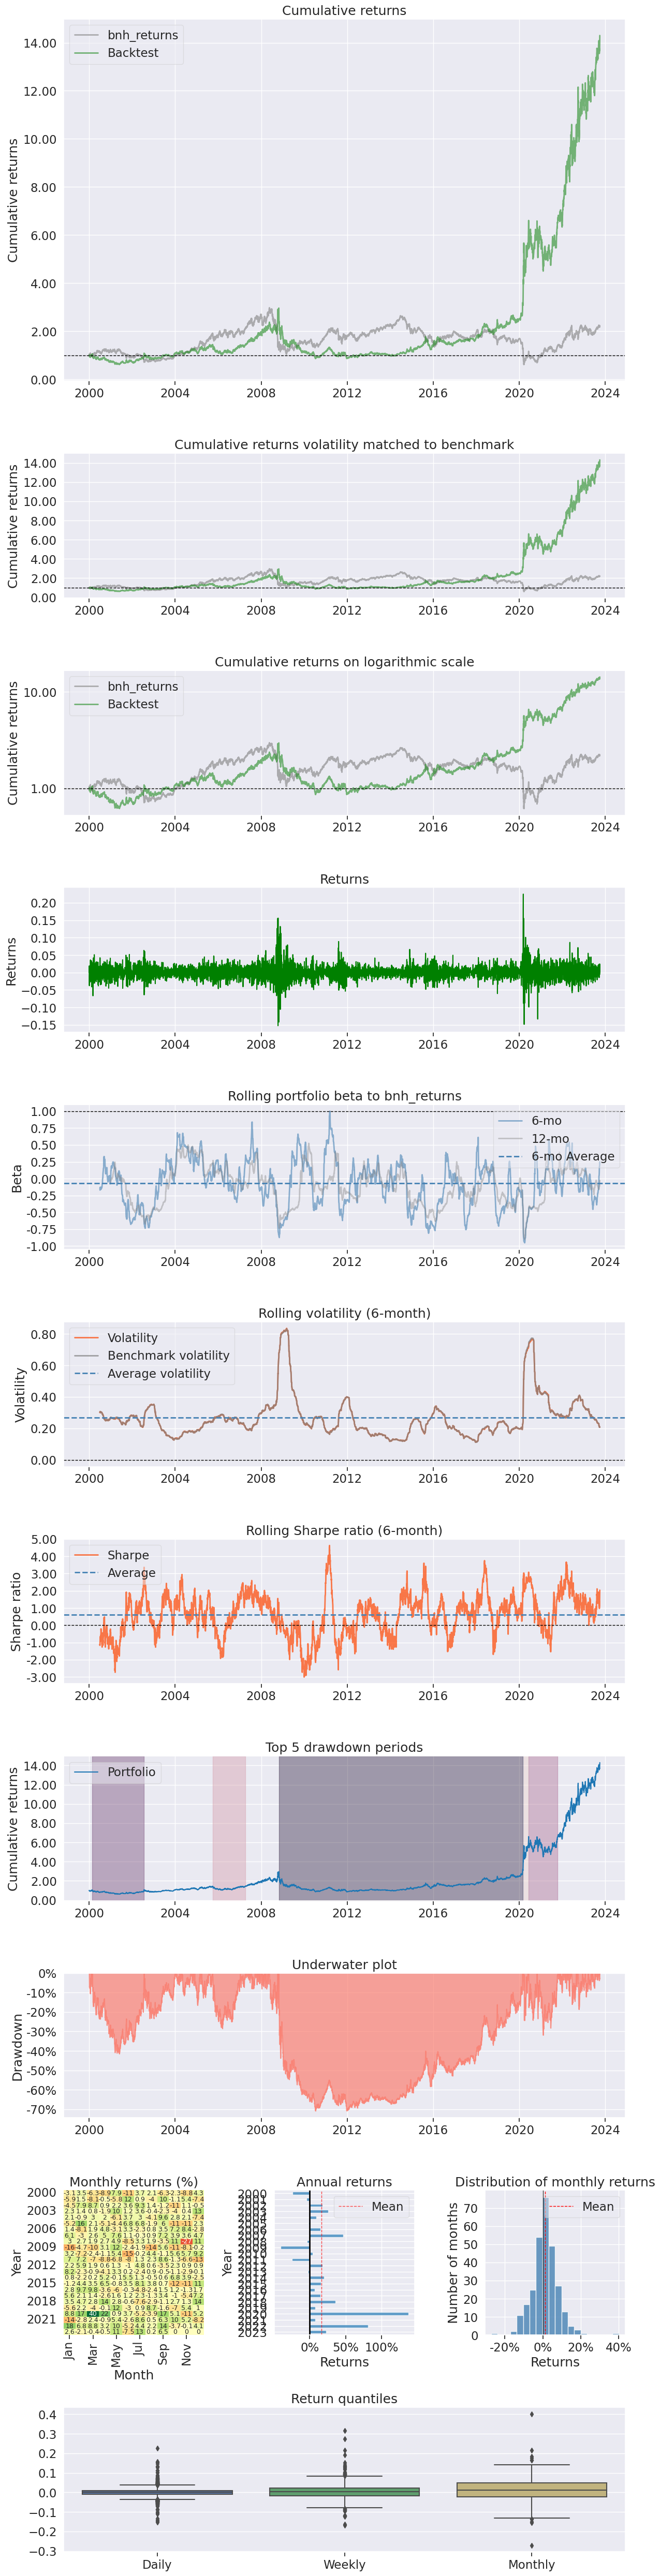

In [8]:
pf.create_returns_tear_sheet(XLE_df['Strategy Returns'], benchmark_rets = XLE_df['bnh_returns'])

Start date,2000-01-03
End date,2023-09-29
Total months,284
,Backtest
Annual return,8.199%
Cumulative returns,547.664%
Annual volatility,25.944%
Sharpe ratio,0.43
Calmar ratio,0.20
Stability,0.81
Max drawdown,-41.991%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.99,2008-11-20,2011-12-19,2020-01-17,2912
1,38.97,2002-11-27,2003-12-09,2008-07-14,1469
2,36.78,2000-05-23,2000-09-20,2001-03-20,216
3,33.47,2022-01-27,2022-07-13,2023-07-13,381
4,29.94,2001-12-05,2002-05-31,2002-11-04,239


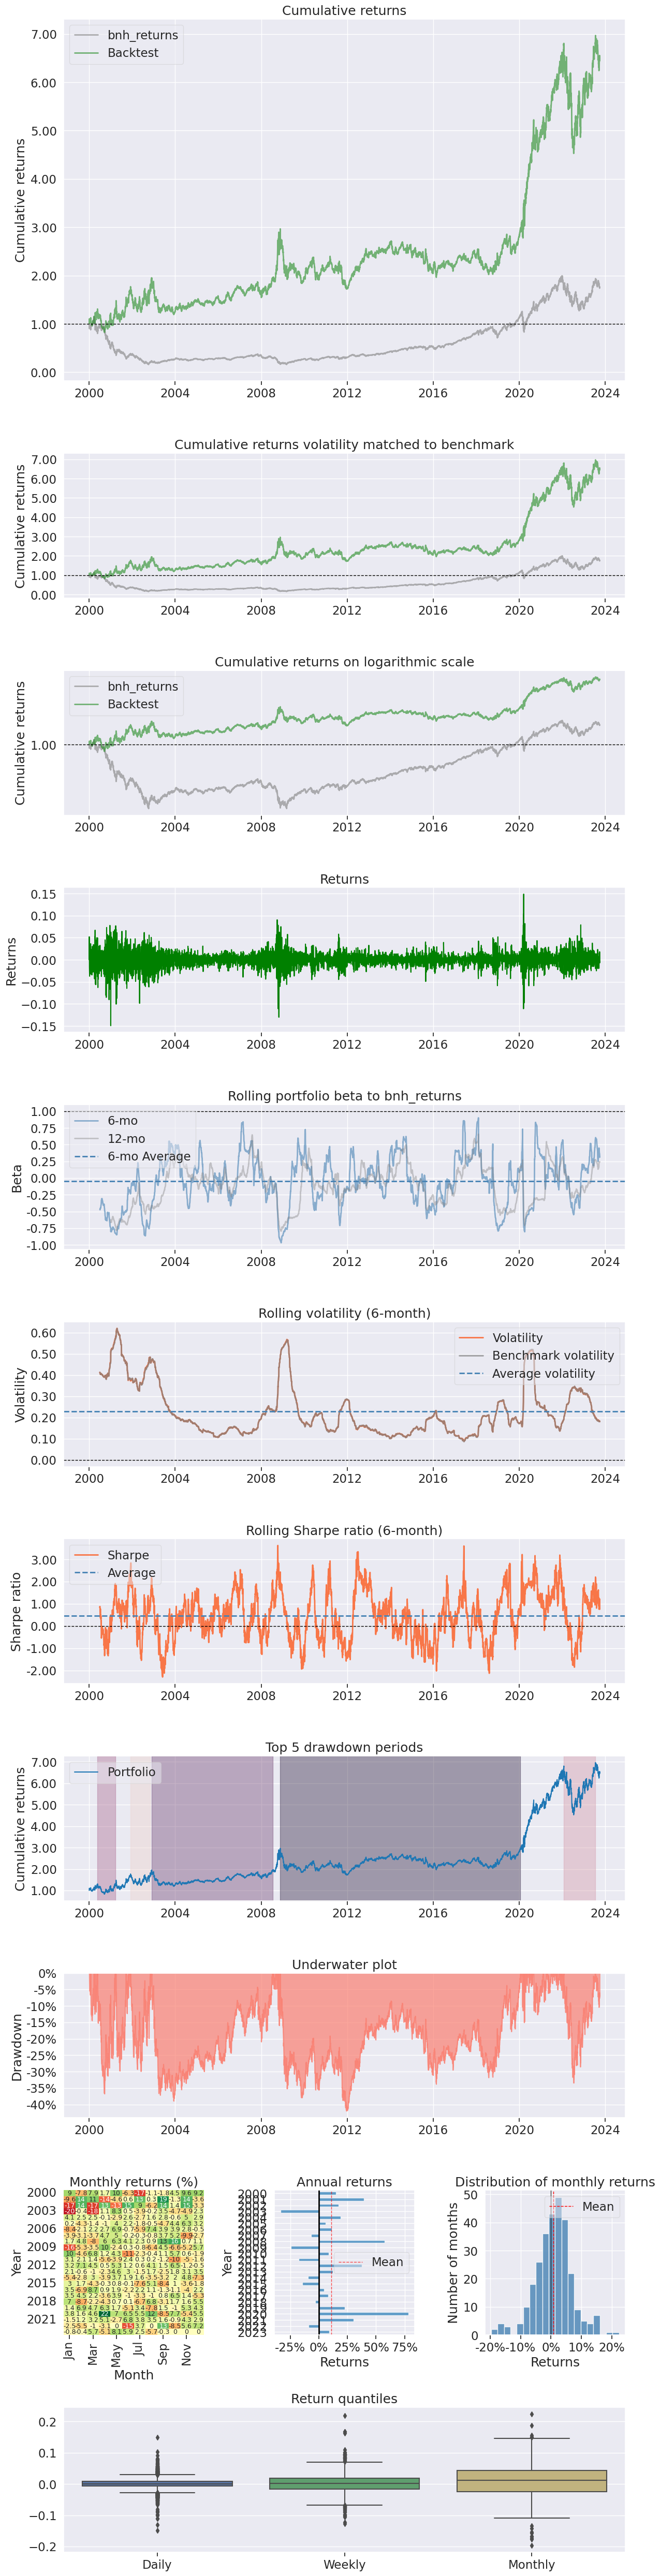

In [9]:
pf.create_returns_tear_sheet(XLK_df['Strategy Returns'], benchmark_rets = XLK_df['bnh_returns'])